In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [39]:
from collections import Counter, OrderedDict
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as models

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit, EnsembleTrainer, get_default_config
from meta import compute_meta_data
from metric import optimize_rounding_bounds, make_cappa_metric, round_regressor_predictions
from normalize import normalize

## Prepare Data

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 19) (1156414, 19)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta),
    F.FeedbackFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [8]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


In [9]:
non_train_cols = ['installation_id', 'game_session', 'accuracy_group']
if U.on_kaggle():
    U.log('Loading features from disk.')
    features = bundle.features()
else:
    U.log('Selecting relevant features.')
    selector = selection.FeatureSelection(
        rules=[('nonzero', selection.non_zero_rows_and_cols)], 
        ignore_cols=non_train_cols)
    features = selector.select(X_trn)
    bundle.save(features, 'features')

Selecting relevant features.
Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 987 of 1020
Keeping only features, selected by every rule.
Final number of features changed from 1020 to 987


In [12]:
if not U.on_kaggle():
    X_trn.to_pickle('/tmp/nn/X_trn.pickle')
    X_tst.to_pickle('/tmp/nn/X_tst.pickle')

## Model Training

In [18]:
def root_mean_squared_error(y_true, y_pred):
    K = tf.keras.backend
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def build_model(num_cols, cat_cols, cat_sizes, 
                output_size, output_act, loss):
    
    def prepare_input(data):
        return [data[num_cols]] + [data[col].T for col in cat_cols]
    
    def numerical(input_size):
        i = L.Input(shape=(input_size,))
        x = L.Dense(2048, activation='relu', use_bias=False)(i)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.5)(x)
        m = models.Model(inputs=i, outputs=x)
        return m
    
    def categorical(cat_sizes):
        inputs, embeds = [], []
        for cat_size in cat_sizes:
            emb_sz = min(50, cat_size // 2)
            i = L.Input(shape=(1,))
            x = L.Embedding(output_dim=emb_sz, input_dim=cat_size)(i)
            inputs.append(i)
            embeds.append(x)
        if len(embeds) > 1:
            x = L.concatenate(embeds)
        x = L.Flatten()(x)
        m = models.Model(inputs=inputs, outputs=x)
        return m
    
    with tf.device('/GPU:1'):
        num = numerical(len(num_cols))
        cat = categorical(cat_sizes)
        x = L.concatenate(num.outputs + cat.outputs)
        x = L.Dense(1024, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(512, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(256, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(128, activation='relu', use_bias=False)(x)
        x = L.BatchNormalization()(x)
        x = L.Dropout(0.25)(x)
        x = L.Dense(output_size, activation=output_act)(x)
        model = models.Model(inputs=num.inputs + cat.inputs, outputs=x)
        opt = tf.keras.optimizer
        model.compile(optimizer='adam', loss=root_mean_squared_error)
        
    return model, prepare_input

In [15]:
if not U.on_kaggle():
    dataset = pd.read_pickle('/tmp/nn/X_trn.pickle')
    target_col = 'accuracy_group'
    cat_cols = ['session_title']
    num_cols = [f for f in features if f not in cat_cols]
    U.log('Normalize numerical columns.')
    normalize(dataset, num_cols, grouping_key='session_title')

Normalize numerical columns.


In [23]:
if not U.on_kaggle():
    U.log('Training model folds.')
    folds = GroupKFold(n_splits=5)
    dataset = dataset.sample(dataset.shape[0])
    group = dataset['installation_id']
    X, y = dataset[features], dataset[target_col]
    oof = np.zeros(len(y), dtype=np.float32)
    cappa = make_cappa_metric(y)
    cv = []
    nets = []

    for i, (trn_idx, val_idx) in enumerate(folds.split(X, y, group), 1):
        U.log(f'Fold #{i}')
        x_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        net, split_input = build_model(
            cat_cols=cat_cols, num_cols=num_cols, 
            cat_sizes=[5], loss=root_mean_squared_error,
            output_size=1, output_act='linear')

        net.fit(x=split_input(x_trn), y=y_trn,
                validation_data=(split_input(x_val), y_val),
                epochs=100, batch_size=2560,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=20)])
        
        oof[val_idx] = net.predict(split_input(x_val)).ravel()
        cv.append(np.mean(cappa(y_val, oof[val_idx])))
        nets.append((net, split_input))

Training model folds.
Fold #1


W0118 20:24:03.007883 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 1s 78us/sample - loss: 3.6413 - val_loss: 1.9627
Epoch 2/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.2878 - val_loss: 1.8822
Epoch 3/100
14152/14152 [==============================] - 0s 30us/sample - loss: 2.0975 - val_loss: 1.8318
Epoch 4/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.9987 - val_loss: 1.8183
Epoch 5/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.9222 - val_loss: 1.6259
Epoch 6/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.7975 - val_loss: 1.3975
Epoch 7/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.7532 - val_loss: 1.4145
Epoch 8/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.6879 - val_loss: 1.3551
Epoch 9/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.598

W0118 20:24:35.194547 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Fold #2


W0118 20:24:36.710418 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 1s 76us/sample - loss: 3.8575 - val_loss: 1.9787
Epoch 2/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.4075 - val_loss: 2.1277
Epoch 3/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.0880 - val_loss: 2.0645
Epoch 4/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.9982 - val_loss: 1.7040
Epoch 5/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.0060 - val_loss: 1.6261
Epoch 6/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.8669 - val_loss: 1.6496
Epoch 7/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.7025 - val_loss: 1.5129
Epoch 8/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.7205 - val_loss: 1.4447
Epoch 9/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.630

W0118 20:25:06.446625 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Fold #3


W0118 20:25:07.763502 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 1s 75us/sample - loss: 3.7127 - val_loss: 2.1834
Epoch 2/100
14152/14152 [==============================] - 0s 30us/sample - loss: 2.2691 - val_loss: 2.0240
Epoch 3/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.0998 - val_loss: 1.8023
Epoch 4/100
14152/14152 [==============================] - 0s 30us/sample - loss: 2.0096 - val_loss: 1.7329
Epoch 5/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.9370 - val_loss: 1.6335
Epoch 6/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.8455 - val_loss: 1.5340
Epoch 7/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.7835 - val_loss: 1.4833
Epoch 8/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.6522 - val_loss: 1.4496
Epoch 9/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.673

Epoch 76/100
14152/14152 [==============================] - 0s 29us/sample - loss: 0.8008 - val_loss: 1.1047
Epoch 77/100
14152/14152 [==============================] - 0s 29us/sample - loss: 0.8096 - val_loss: 1.1293
Epoch 78/100
14152/14152 [==============================] - 0s 29us/sample - loss: 0.7921 - val_loss: 1.1715
Epoch 79/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.7968 - val_loss: 1.1679
Epoch 80/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.7792 - val_loss: 1.1516
Epoch 81/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.7822 - val_loss: 1.1338
Epoch 82/100
14152/14152 [==============================] - 0s 29us/sample - loss: 0.7869 - val_loss: 1.1522
Epoch 83/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.7648 - val_loss: 1.1298


W0118 20:25:46.014004 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Fold #4


W0118 20:25:47.347792 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 1s 76us/sample - loss: 3.8440 - val_loss: 2.0038
Epoch 2/100
14152/14152 [==============================] - 0s 28us/sample - loss: 2.2572 - val_loss: 1.8944
Epoch 3/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.1116 - val_loss: 1.8092
Epoch 4/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.9963 - val_loss: 1.6620
Epoch 5/100
14152/14152 [==============================] - 0s 29us/sample - loss: 2.0094 - val_loss: 1.5852
Epoch 6/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.8077 - val_loss: 1.6082
Epoch 7/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.7898 - val_loss: 1.4699
Epoch 8/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.6780 - val_loss: 1.3282
Epoch 9/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.620

W0118 20:26:18.153213 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Fold #5


W0118 20:26:19.482959 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 1s 77us/sample - loss: 3.1089 - val_loss: 1.9792
Epoch 2/100
14152/14152 [==============================] - 0s 30us/sample - loss: 2.3372 - val_loss: 1.8633
Epoch 3/100
14152/14152 [==============================] - 0s 30us/sample - loss: 2.0613 - val_loss: 1.8495
Epoch 4/100
14152/14152 [==============================] - 0s 29us/sample - loss: 1.9830 - val_loss: 1.9746
Epoch 5/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.9125 - val_loss: 1.6615
Epoch 6/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.7821 - val_loss: 1.5323
Epoch 7/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.7015 - val_loss: 1.4303
Epoch 8/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.6661 - val_loss: 1.3659
Epoch 9/100
14152/14152 [==============================] - 0s 30us/sample - loss: 1.574

Epoch 76/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8399 - val_loss: 1.2212
Epoch 77/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8366 - val_loss: 1.2047
Epoch 78/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8365 - val_loss: 1.1713
Epoch 79/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8257 - val_loss: 1.2231
Epoch 80/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8270 - val_loss: 1.1966
Epoch 81/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8310 - val_loss: 1.1825
Epoch 82/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8812 - val_loss: 1.2499
Epoch 83/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.8236 - val_loss: 1.1823
Epoch 84/100
14152/14152 [==============================] - 0s 30us/sample - loss: 0.7915 - val_loss: 1.1878
Epoch 85/100
14152/

W0118 20:26:59.875665 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


## Submission

In [41]:
preds = np.zeros((X_tst.shape[0], len(nets)), dtype=np.float32)
for i, (net, prep) in enumerate(nets):
    preds[:, i] = net.predict(prep(X_tst)).ravel()
avg_preds = preds.mean(axis=1)

W0118 20:37:23.776040 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>
W0118 20:37:24.054708 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>
W0118 20:37:24.299551 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"}), <class 'NoneType'>
W0118 20:37:24.539256 140088942450496 training.py:504] Falling back from v2 loop because of error: Failed to find d

In [45]:
rounder = PredictionsRoudner(y)
y_hat, bounds = rounder(oof)
cappa(y, y_hat)

0.49116735304187487

In [ ]:
if U.on_kaggle():
    nets = bundle.models(model='nets', version='001')
    rounder = PredictionsRoudner(y)
    y_hat, bounds = rounder(oof)
    normalize(X_tst, num_cols, grouping_key='session_title')
    preds = np.zeros((X_tst.shape[0], len(nets)), dtype=np.float32)
    for i, (net, prep) in enumerate(nets):
        preds[:, i] = net.predict(prep(X_tst)).ravel()
    avg_preds = preds.mean(axis=1)
    bounds = bundle.bounds()

## Submission

In [22]:
algo = 'lightgbm'
version = '021'

U.log('Loading relevant features list from disk.')
features = [c for c in X_trn.columns 
            if c not in ('installation_id', 'game_session', 'accuracy_group')]
U.log(f'Total number of features: {len(features)}')

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log(f'Training model: {algo}')
    cappa = make_cappa_metric(X_trn['accuracy_group'])
    trainer = EnsembleTrainer(algo=algo, cv_metrics={'cappa': cappa})
    fold = GroupKFold(n_splits=5)
    config = get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.5)
    U.set_nested(config, 'model_params.bagging_fraction', 0.5)
    U.set_nested(config, 'model_params.learning_rate', 0.003)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    U.log('Saving the trained models')
    bundle.save(result.models, f'models_{algo}_{version}')
    U.log('Saving the optimal rounding bounds')
    bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal bounds: {bounds}')
    bundle.save(bounds, 'bounds')

Loading relevant features list from disk.
Total number of features: 1017
Training model: lightgbm
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.17672	val's rmse: 1.18593
[200]	trn's rmse: 1.11692	val's rmse: 1.13068
[300]	trn's rmse: 1.07252	val's rmse: 1.0909
[400]	trn's rmse: 1.03928	val's rmse: 1.06257
[500]	trn's rmse: 1.01117	val's rmse: 1.03984
[600]	trn's rmse: 0.989669	val's rmse: 1.02333
[700]	trn's rmse: 0.972189	val's rmse: 1.01092
[800]	trn's rmse: 0.957964	val's rmse: 1.00189
[900]	trn's rmse: 0.945652	val's rmse: 0.994829
[1000]	trn's rmse: 0.93478	val's rmse: 0.989016
[1100]	trn's rmse: 0.925694	val's rmse: 0.984744
[1200]	trn's rmse: 0.917438	val's rmse: 0.981113
[1300]	trn's rmse: 0.910309	val's rmse: 0.978574
[1400]	trn's rmse: 0.903554	val's rmse: 0.976581
[1500]	trn's rmse: 0.897332	val's rmse: 0.97493
[1600]	trn's rmse: 0.891442	val's rmse: 0.973439
[1700]	trn's rmse: 0.88591	val's rmse: 0.972467
[1800]	trn

In [27]:
from metric import PredictionsRoudner

In [28]:
rounder = PredictionsRoudner(train_target=X_trn['accuracy_group'])

In [30]:
preds, bounds_dist = rounder(result.oof)

In [31]:
bounds_dist

[1.3515825283399336, 1.8037354713648037, 2.065028190612793]

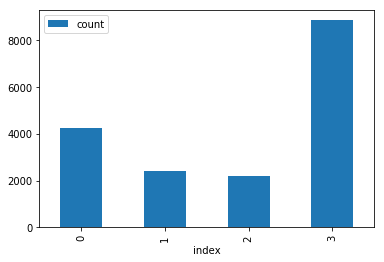

In [40]:
(pd.Series(preds)
 .value_counts()
 .rename('count')
 .reset_index()
 .sort_values(by='index')
 .plot.bar(x='index', y='count'))

In [42]:
if not U.on_kaggle():
    import os
    #features = bundle.features()
    # bounds = bundle.bounds()
    bounds = bounds_dist
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 1017
Loading external models: lightgbm v021.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/models_lightgbm_021.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_021.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
Packaging helper scripts into dataset.
../selection.py --> /home/ck/data/bowl2019/external/selection.py
../encode.py --> /home/ck/data/bowl2019/external/encode.py
../features.py --> /home/ck/data/bowl2019/external/features.py
../training.py --> /home/ck/data/bowl2019/external/

In [43]:
%matplotlib inline

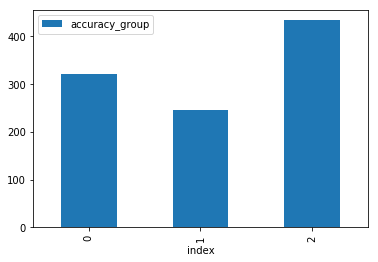

In [44]:
pd.read_csv('submission.csv')['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()

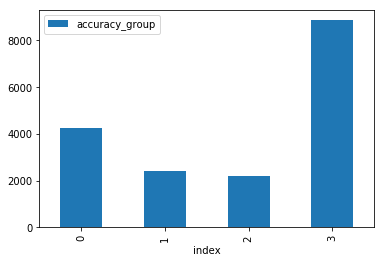

In [45]:
X_trn['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()